In [1]:
import tensorflow as tf
import os, os.path
import sys
import time
import urllib
import random
import gzip

import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import coo_matrix
from sklearn.utils import shuffle

In [2]:
def cached_download(filename):
    """
    Only download data files if necessary.
    """
    try:
        os.stat('final')
    except:
        os.mkdir('final')
    #
    filepath = os.path.join('final', filename)
    #
    if not os.path.isfile(filepath):
        filepath, headers = urllib.request.urlretrieve(URLBASE + filename, filepath)
    #
    return filepath

In [3]:
def unpack_files(imagefile, labelsfile, count):
    with gzip.open(imagefile) as f:
        f.read(16)
        buf = f.read(IMAGEW * IMAGEH * count)
        images = np.frombuffer(buf, dtype = np.uint8).astype(np.float32)
        images = images.reshape(count, IMAGEW, IMAGEH)
    with gzip.open(labelsfile) as f:
        f.read(8)
        labels = np.frombuffer(f.read(1 * count), dtype = np.uint8).astype(np.int64)
    
    return (images, labels)

In [4]:
IMAGEW = 28
IMAGEH = 28

In [5]:
URLBASE = 'http://yann.lecun.com/exdb/mnist/'

images, labels = unpack_files('./MNIST_data/train-images-idx3-ubyte.gz', 
                              './MNIST_data/train-labels-idx1-ubyte.gz', 
                              60000)

In [6]:
images.shape

(60000, 28, 28)

In [7]:
Xfiles = images
yfiles = labels
LABELS = 10
idim = IMAGEW * IMAGEH
odim = LABELS
N = 60000
batch_size = 50

hdim = 25

In [8]:
images.shape

(60000, 28, 28)

In [9]:
imgmatrix = np.vstack([np.hstack([images[random.randrange(len(labels)),:,:] for i in range(10)]) for j in range(10)])

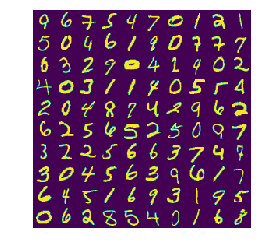

In [10]:
plt.imshow(imgmatrix, interpolation = 'nearest')
plt.axis('off')
plt.show()

In [11]:
Xfiles = images.reshape(len(labels), -1)

# LEARNING RATE

In [12]:
epsilon = 0.001

LAMBDA = 0.05

# MODEL

In [13]:
def soft_max(scores):
    """
    Convert scores to probabilities.
    """
    exp_scores = np.exp(scores)
    return exp_scores / np.sum(exp_scores, axis = 1, keepdims = True)

def predict(model, x):
    """
    Generate a prediction via forward propagation.
    """
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Input values to hidden layer.
    z1 = x.dot(W1) + b1
    # Activation of hidden layer.
    a1 = np.tanh(z1)
    # Input to ouput layer.
    z2 = a1.dot(W2) + b2
    
    return soft_max(z2)

def predict_class(model, x):
    return np.argmax(predict(model, x), axis = 1)

In [26]:
def loss(model, x, y):
    
    """
    Evaluate cross-entropy loss.
    """
    W1, W2 = model['W1'], model['W2']
    #
    probs = predict(model, x)
    #
    L = np.sum(-np.log(probs[range(len(y)), y]))
    # Add regularization.
    #print('LAMBDA/2)')
    L += LAMBDA / 2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    #
    #print('L/N')
    return L / (len(y))

In [27]:
def build_model(hdim, model = None, passes = 20000, verbose = False):
    
    X = batch_x
    y = batch_y
    """
    Train model using backward propagation and batch gradient descent.
    
    :param hdim: Number of hidden nodes.
    :param passes: Number of iterations.
    :param verbose: Whether or not to produce status information.
    :return: data frame.
    """
    np.random.seed(20)
    
    ##BATCHES
    ## ADD A CODE FOR EXISTING MODEL, Z3 IS DEFINED
    #
    # Initialise the weights and biases.
    #
    if model:
        W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
        
    else:
        np.random.seed(20)
        W1 = np.random.randn(idim, hdim) / np.sqrt(idim)
        b1 = np.zeros((1, hdim))
        W2 = np.random.randn(hdim, odim) / np.sqrt(hdim)
        b2 = np.zeros((1, odim))
#     try:
#         model2
#     except:
#         model2 = None
    
#     if model2 is None:
#         np.random.seed(20)
#         W1 = np.random.randn(idim, hdim) / np.sqrt(idim)
#         b1 = np.zeros((1, hdim))
#         W2 = np.random.randn(hdim, odim) / np.sqrt(hdim)
#         b2 = np.zeros((1, odim))
#         print('METHOD 1')
#     else:
#         W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
#         print('METHOD 2')
        
    #
    # W1 is a (idim, hdim) array
    # b1 is a (1, hdim) array
    # W2 is a (hdim, odim) array
    # b2 is a (1, odim) array
    #
    # X is a (N, idim) array
    # y is a (N, 1) array
    
    #for i in range(0, passes):
        
        # Generate predictions with current model via forward propagation.
        #
        # (N, idim) x (idim, hdim) -> (N, hdim)
        #
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
        #
        # z1 is input to the hidden layer.
        # a1 is output from the hidden layer (after applying the activation function).
        #
        # (N, hdim) x (hdim, odim) -> (N, odim)
        #
    z2 = a1.dot(W2) + b2
        #
        # z2 is input to the output layer.
        #
    delta = soft_max(z2)
        #
        # delta is a (   N, odim) array

        # Backward propagation.
        #
        # Takes advantage of d/dx tanh(x) = 1 - tanh(x)^2.
        #
    delta[range(batch_size), y] -= 1
        #
        # (idim, N) x (N, odim) -> (idim, odim)
        #
    dW2 = (a1.T).dot(delta)
    db2 = np.sum(delta, axis = 0, keepdims = True)
    delta2 = delta.dot(W2.T) * (1 - np.power(a1, 2))
    dW1 = np.dot(X.T, delta2)
    db1 = np.sum(delta2, axis=0)

        # Update model parameters, including regularisation.
        #
    W1 += -epsilon * (dW1 + LAMBDA * W1)
    b1 += -epsilon * db1
    W2 += -epsilon * (dW2 + LAMBDA * W2)
    b2 += -epsilon * db2
        
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        

        
    
    return model

In [125]:
epsilon = 0.00005
LAMBDA = 0.002


In [126]:
model=None

In [124]:
print('NEW')

for iter in range(100):
    X_sparse = coo_matrix(Xfiles)
    Xfiles, X_sparse, yfiles = shuffle(Xfiles, X_sparse, yfiles, random_state=0)
    for i in range(int(N/batch_size)):
        batch_x = Xfiles[((i)*batch_size):((i+1)*batch_size),]
        batch_y = yfiles[((i)*batch_size):((i+1)*batch_size)]
        #print('LOOP')
        #print(i)
        #print(batch_y[0])
        model = build_model(3, model = model, verbose = True)
    print("iteration %i: Loss = %f" %(iter, loss(model, Xfiles, yfiles)))
    
    

NEW
iteration 0: Loss = 0.193685
iteration 1: Loss = 0.195822
iteration 2: Loss = 0.200358
iteration 3: Loss = 0.193664


KeyboardInterrupt: 

In [112]:
labels_predict = predict_class(model, Xfiles)
yfiles[0:10]

array([2, 9, 8, 0, 8, 9, 4, 5, 2, 7])

In [113]:
labels_predict[0:10]

array([2, 9, 8, 0, 8, 9, 4, 5, 2, 7])

In [119]:
sum(labels_predict == yfiles) / len(yfiles)

0.9438333333333333

# TEST

In [120]:
test_images, test_labels = unpack_files('./MNIST_data/t10k-images-idx3-ubyte.gz', './MNIST_data/t10k-labels-idx1-ubyte.gz', 10000)

In [121]:
test_images = test_images.reshape(len(test_labels), -1)

In [122]:
test_labels_predict = predict_class(model, test_images)

In [123]:
sum(test_labels_predict == test_labels) / len(test_labels)

0.93840000000000001